<a href="https://colab.research.google.com/github/zaellis/ECE6254_final_project/blob/main/ECE6254_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECE6254 Final Project
|Colaborators|||
|--------------|---------------|---------|
|Zachary Ellis | Daniel Jacobs | Changxuan Yao |

## Description

For our final project in ECE6254 at Georgia Tech we decided to investigate Google's [scaaml](https://github.com/google/scaaml) repository which demonstrates a machine learning assited side-channel attack on the TinyAES peripheral in the stm32f415 microcontroller. We investigate the performance of these pretrained models on different attack vectors and do some anaylsis on their performance.

## Retrieve the scaaml repo

In [ ]:
!git clone https://github.com/google/scaaml.git scaaml_git

Cloning into 'scaaml_git'...
remote: Enumerating objects: 1256, done.
remote: Counting objects: 100% (560/560), done.
remote: Compressing objects: 100% (283/283), done.
remote: Total 1256 (delta 399), reused 345 (delta 265), pack-reused 696
Receiving objects: 100% (1256/1256), 528.98 KiB | 3.09 MiB/s, done.
Resolving deltas: 100% (817/817), done.


## Download Models and Datasets and Unzip

In [41]:
%cd /content/scaaml_git/scaaml_intro/
!wget -v -N https://storage.googleapis.com/scaaml-public/scaaml_intro/datasets.zip https://storage.googleapis.com/scaaml-public/scaaml_intro/models.zip
import os.path
if(not os.path.isdir("models/")):
  !unzip models.zip
if(not os.path.isdir("datasets/")):
  !unzip datasets.zip

/content/scaaml_git/scaaml_intro
--2023-04-16 15:30:51--  https://storage.googleapis.com/scaaml-public/scaaml_intro/datasets.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.193.128, 173.194.194.128, 173.194.196.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.193.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8769223087 (8.2G) [application/zip]
Saving to: ‘datasets.zip’

datasets.zip        100%[===================>]   8.17G   178MB/s    in 67s     

2023-04-16 15:31:59 (125 MB/s) - ‘datasets.zip’ saved [8769223087/8769223087]

--2023-04-16 15:31:59--  https://storage.googleapis.com/scaaml-public/scaaml_intro/models.zip
Reusing existing connection to storage.googleapis.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 616166351 (588M) [application/zip]
Saving to: ‘models.zip’

models.zip          100%[===================>] 587.62M   161MB/s    in 3.8s    

2023-04-16 15:32:03 (157 MB/s) 

## Run setup.py and install LIME

In [42]:
%cd /content/scaaml_git/
!python setup.py develop
%cd /content/scaaml_git/scaaml_intro/
!pip install lime

/content/scaaml_git
/usr/local/lib/python3.9/dist-packages/setuptools/dist.py:547: UserWarning: Normalizing '2.0.1r1681659315' to '2.0.1.post1681659315'
  warnings.warn(tmpl.format(**locals()))
running develop
/usr/local/lib/python3.9/dist-packages/setuptools/command/easy_install.py:144: EasyInstallDeprecationWarning: easy_install command is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
running egg_info
writing scaaml.egg-info/PKG-INFO
writing dependency_links to scaaml.egg-info/dependency_links.txt
writing requirements to scaaml.egg-info/requires.txt
writing top-level names to scaaml.egg-info/top_level.txt
reading manifest file 'scaaml.egg-info/SOURCES.txt'
adding license file 'LICENSE'
writing manifest file 'scaaml.egg-info/SOURCES.txt'
running build_

## Run Key Recovery Demo for 1 Byte
If this does not work. Go to the `Runtime` tab and click `Restart runtime` before attempting to re-run this cell

In [3]:
%cd /content/scaaml_git/scaaml_intro/
%load_ext autoreload
%autoreload 2

import json
import numpy as np
from tqdm.auto import tqdm
from collections import defaultdict
from tensorflow.keras import metrics
from tabulate import tabulate
import matplotlib.pyplot as plt
import sys
sys.path.append("/content/scaaml_git/scaaml")
from scaaml.aes import ap_preds_to_key_preds
from scaaml.plot import plot_trace, plot_confusion_matrix
from scaaml.utils import tf_cap_memory, from_categorical
from scaaml.model import get_models_by_attack_point, get_models_list, load_model_from_disk
from scaaml.intro.generator import list_shards, load_attack_shard
from scaaml.utils import hex_display, bytelist_to_hex

target = 'stm32f415_tinyaes'
tf_cap_memory()
target_config = json.loads(open("config/" + target + '.json').read())
BATCH_SIZE = target_config['batch_size']
TRACE_LEN = target_config['max_trace_len']


available_models = get_models_by_attack_point(target_config)

DATASET_GLOB = "datasets/%s/test/*" % target_config['algorithm']
shard_paths  = list_shards(DATASET_GLOB, 256)

/content/scaaml_git/scaaml_intro
Attack point    status      Num available models
--------------  --------  ----------------------
sub_bytes_out   complete                      16
sub_bytes_in    complete                      16
key             complete                      16


In [2]:
#@title Select Attack Point and Key Byte for 1 Byte Test { display-mode: "form" }

# let's select an attack point that have all the needed models -- Key is not a good target: it doesn't work
ATTACK_POINT = 'sub_bytes_in' #@param ["sub_bytes_in", "sub_bytes_out", "key"]

# let's also pick the key byte we want to use SCAAML to recover and load the related model
ATTACK_BYTE = 0 #@param [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15] {type:"raw"}

# load model
model = load_model_from_disk(available_models[ATTACK_POINT][ATTACK_BYTE])

## Run Selected Model on 10 Power Traces

In [3]:
NUM_TRACES = 10  # maximum number of traces to use to recover a given key byte. 10 is already overkill
correct_prediction_rank = defaultdict(list)
y_pred = []
y_true = []
model_metrics = {"acc": metrics.Accuracy()}
for shard in tqdm(shard_paths, desc='Recovering bytes', unit='shards'):
    keys, pts, x, y = load_attack_shard(shard, ATTACK_BYTE, ATTACK_POINT, TRACE_LEN, num_traces=NUM_TRACES)

    # prediction
    predictions = model.predict(x)
    
    # computing byte prediction from intermediate predictions
    key_preds = ap_preds_to_key_preds(predictions, pts, ATTACK_POINT)
    
    c_preds = from_categorical(predictions)
    c_y = from_categorical(y)
    # metric tracking
    for metric in model_metrics.values():
        metric.update_state(c_y, c_preds)
    # for the confusion matrix
    y_pred.extend(c_preds)
    y_true.extend(c_y)
    
    # accumulating probabilities and checking correct guess position.
    # if all goes well it will be at position 0 (highest probability)
    # see below on how to use for the real attack
    
    
    key = keys[0] # all the same in the same shard - not used in real attack
    vals = np.zeros((256))
    for trace_count, kp in enumerate(key_preds):
        vals = vals  + np.log10(kp + 1e-22) 
        guess_ranks = (np.argsort(vals, )[-256:][::-1])
        byte_rank = list(guess_ranks).index(key)
        correct_prediction_rank[trace_count].append(byte_rank)

Recovering bytes:   0%|          | 0/256 [00:00<?, ?shards/s]

1/1 [==============================] - 0s 422ms/step


## Print Metrics

Accuracy: 0.48


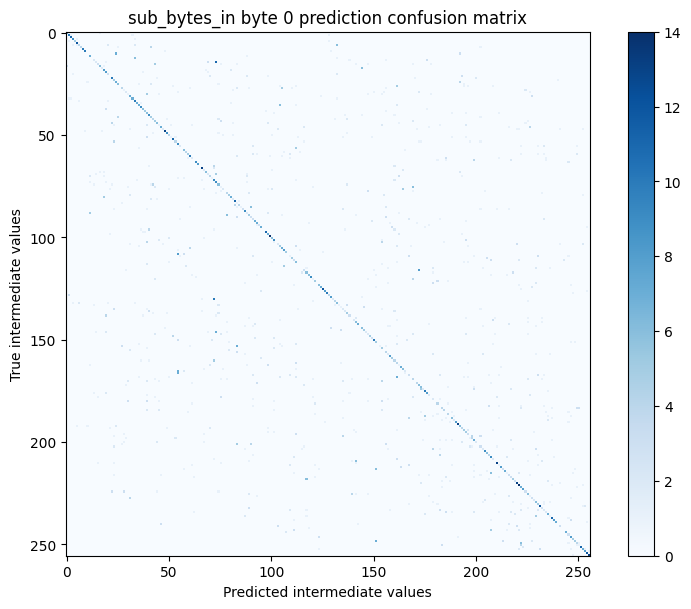

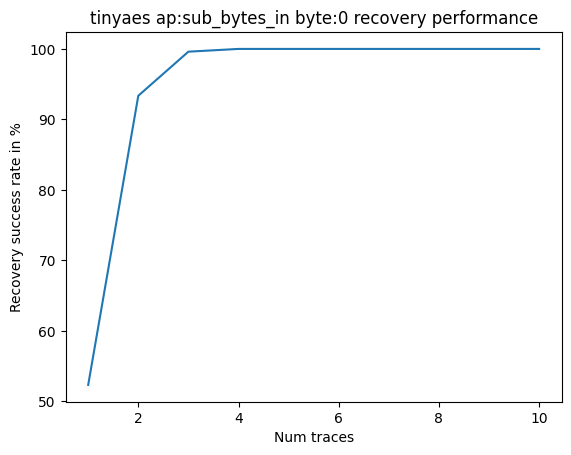

metric              num traces  % of keys
----------------  ------------  -----------
min traces                1     52.3
max traces                4     100.0
cumulative score         86.33  -


In [4]:
print("Accuracy: %.2f" % model_metrics['acc'].result())


plot_confusion_matrix(y_true, y_pred, normalize=True, title="%s byte %s prediction confusion matrix" % (ATTACK_POINT, ATTACK_BYTE))

NUM_TRACES_TO_PLOT = 10
avg_preds = np.array([correct_prediction_rank[i].count(0) for i in range(NUM_TRACES_TO_PLOT)])
y = avg_preds / len(correct_prediction_rank[0]) * 100 
x = [i + 1 for i in range(NUM_TRACES_TO_PLOT)]
plt.plot(x, y)
plt.xlabel("Num traces")
plt.ylabel("Recovery success rate in %")
plt.title("%s ap:%s byte:%s recovery performance" % (target_config['algorithm'], ATTACK_POINT, ATTACK_BYTE))
plt.show()

min_traces = 0
max_traces = 0
cumulative_aa = 0
for idx, val in enumerate(y):
    cumulative_aa += val
    if not min_traces and val > 0:
        min_traces = idx + 1
    if not max_traces and val == 100.0:
        max_traces = idx + 1
        break 

cumulative_aa = round( cumulative_aa / (idx + 1), 2) # divide by the number of steps

rows = [
    ["min traces", min_traces, round(y[min_traces -1 ], 1)],
    ["max traces", max_traces, round(y[max_traces - 1], 1)],
    ["cumulative score", cumulative_aa, '-'] 
]
print(tabulate(rows, headers=['metric', 'num traces', '% of keys']))

In [7]:
#@title Select Attack Point and Number of Attack Bytes to Explain { display-mode: "form" }

# let's select an attack point that have all the needed models -- Key is not a good target: it doesn't work
ATTACK_POINT = 'sub_bytes_in' #@param ["sub_bytes_in", "sub_bytes_out", "key"]

# let's also pick the key byte we want to use SCAAML to recover and load the related model
NUM_BYTES = 12 #@param [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16] {type:"raw"}

#Choose whether to download runfile to protect data in case runtime disconnected
download_runfile = True #@param {type:"boolean"}

## Run Explainer on Selected Attack Point and Bytes and Save Run Data to File

In [8]:
import tensorflow as tf
import lime
from lime import lime_tabular
import pickle

fd_datafile = open("run_data.pickle", "wb")

shard = shard_paths[0]

NUM_TRACES = 256

byte_data = []
for j in range(NUM_BYTES):
  model = load_model_from_disk(available_models[ATTACK_POINT][j])
  keys, pts, x, y = load_attack_shard(shard, j, ATTACK_POINT, TRACE_LEN, num_traces=NUM_TRACES)

  stop = int(0.8 * NUM_TRACES)
  x_train = x[:stop,:,:]
  x_test = x[stop:,:,:]

  y_train = y[:stop,:]
  y_test = y[stop:,:]

  explainer = lime_tabular.RecurrentTabularExplainer(x_train,training_labels=y_train,feature_names=["voltage"])

  runs = []

  for i in range(4):
    exp = explainer.explain_instance(np.expand_dims(x_test[i],axis=0), model.predict, num_features=20000)
    runs.append(exp.as_list())
  byte_data.append(runs)

pickle.dump(byte_data, fd_datafile)

fd_datafile.close()

if(download_runfile):
  from google.colab import files
  files.download('run_data.pickle')


157/157 [==============================] - 254s 2s/step


157/157 [==============================] - 258s 2s/step


157/157 [==============================] - 268s 2s/step


157/157 [==============================] - 263s 2s/step


157/157 [==============================] - 261s 2s/step


157/157 [==============================] - 251s 2s/step


157/157 [==============================] - 262s 2s/step


157/157 [==============================] - 251s 2s/step


157/157 [==============================] - 250s 2s/step


157/157 [==============================] - 263s 2s/step


157/157 [==============================] - 257s 2s/step


157/157 [==============================] - 256s 2s/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Plot Explainer Data

In [9]:
import pickle
fd_datafile = open("run_data_0.pickle", 'rb')

byte_data = pickle.load(fd_datafile)
fd_datafile.close()

fd_datafile = open("run_data.pickle", 'rb')

byte_data_new = pickle.load(fd_datafile)
fd_datafile.close()

for i in range(len(byte_data_new)):
  byte_data.append(byte_data_new[i])

NUM_BYTES = 16

/content/scaaml_git/scaaml_intro


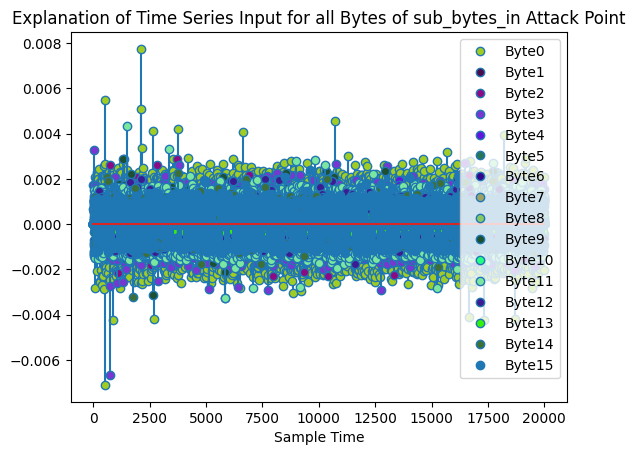

In [11]:
%cd /content/scaaml_git/scaaml_intro/
import matplotlib.pyplot as plt
import re
import pickle
from numpy import random

#fd_datafile = open("run_data.pickle", 'rb')

#byte_data = pickle.load(fd_datafile)
#fd_datafile.close()

filter_time = re.compile(r't-(\d+)')

markerline = [0] * 16

i = 0

for runs in byte_data:
  try:
    x_full = [0] * TRACE_LEN
  except:
    x_full = [0] * 20000
    TRACE_LEN = 20000
  for feature_list in runs:
    for feature in feature_list[:250]:
      time = int(filter_time.search(feature[0]).group(1))
      x_full[(TRACE_LEN - 1) - time] += feature[1]
  markerline[i], stemlines, _ = plt.stem(x_full)
  i += 1

for i in range(NUM_BYTES - 1):
  c = color = random.rand(3)
  plt.setp(markerline[i], 'markerfacecolor', color)
  #plt.setp(markerline[1], 'markerfacecolor', 'lightcoral')
  #plt.setp(markerline[2], 'markerfacecolor', 'red')
  #plt.setp(markerline[3], 'markerfacecolor', 'peru')
  #plt.setp(markerline[4], 'markerfacecolor', 'gold')
  #plt.setp(markerline[5], 'markerfacecolor', 'chartreuse')
  #plt.setp(markerline[6], 'markerfacecolor', 'darkgreen')
  #plt.setp(markerline[7], 'markerfacecolor', 'turquoise')
  #plt.setp(markerline[8], 'markerfacecolor', 'white')
  #plt.setp(markerline[9], 'markerfacecolor', 'orchid')
  #plt.setp(markerline[10], 'markerfacecolor', 'rebeccapurple')
  #plt.setp(markerline[11], 'markerfacecolor', 'lime')
  #plt.setp(markerline[12], 'markerfacecolor', 'darkorange')
  #plt.setp(markerline[13], 'markerfacecolor', 'slategrey')
  #plt.setp(markerline[14], 'markerfacecolor', 'olive')
  #plt.setp(markerline[15], 'markerfacecolor', 'blue') #keep last one as default color

if(NUM_BYTES < 16):
  plt.title("Explanation of Time Series Input for First " + str(NUM_BYTES) + " of " + str(ATTACK_POINT) + " Attack Point" )
else:
  plt.title("Explanation of Time Series Input for all Bytes of " + str(ATTACK_POINT) + " Attack Point" )

plt.xlabel("Sample Time")

legend_names = ["Byte" + str(i) for i in range(NUM_BYTES)]
plt.legend(markerline, legend_names, loc='upper right')

filename = str(ATTACK_POINT) + '_' + str(NUM_BYTES) + '.png'
plt.savefig(filename)
plt.show()
